In [2]:
pip install -U scikit-learn scipy matplotlib

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [3]:
!python 'setup.py' install

running install
running bdist_egg
running egg_info
writing data_depth.egg-info/PKG-INFO
writing dependency_links to data_depth.egg-info/dependency_links.txt
writing requirements to data_depth.egg-info/requires.txt
writing top-level names to data_depth.egg-info/top_level.txt
reading manifest file 'data_depth.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'data_depth.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib
running build_py
copying depth/multivariate/import_CDLL.py -> build/lib.macosx-10.9-x86_64-3.9/depth/multivariate
running build_ext
creating build/bdist.macosx-10.9-x86_64/egg
copying build/lib.macosx-10.9-x86_64-3.9/ddalpha.cpython-39-darwin.so -> build/bdist.macosx-10.9-x86_64/egg
copying build/lib.macosx-10.9-x86_64-3.9/depth_wrapper.cpython-39-darwin.so -> build/bdist.macosx-10.9-x86_64/egg
creating build/bdist.macosx-10.9-x86_64/egg/depth
creating build/bdist.macosx-10.9-x86_64/egg

In [4]:
!python 'setup.py' build

running build
running build_py
running egg_info
writing data_depth.egg-info/PKG-INFO
writing dependency_links to data_depth.egg-info/dependency_links.txt
writing requirements to data_depth.egg-info/requires.txt
writing top-level names to data_depth.egg-info/top_level.txt
reading manifest file 'data_depth.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'data_depth.egg-info/SOURCES.txt'
running build_ext


In [5]:
import numpy as np
import matplotlib.pyplot as plt

## Create sample dataset
We use the multivariate_normal function in numpy, using the speficiations given in the Anomaly detection paper.

In [6]:
mean1 = (1, 1)
mean2 = (3.181, -0.222)
cov1 = [[1, 1], [1, 2]]
cov2 = [[i / 36 for i in j] for j in cov1]

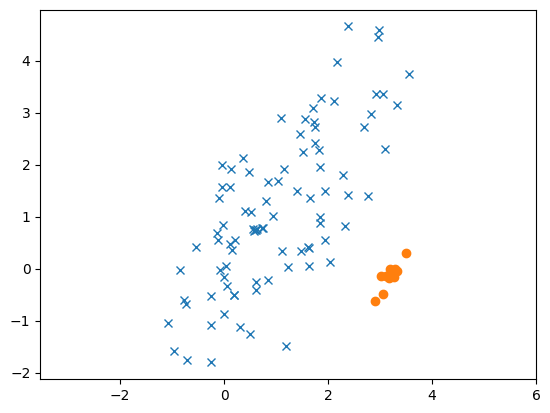

In [7]:
# use fixed random seed for reproducable results
rng = np.random.default_rng(322180440709489274700185804004290683059)
x, y = rng.multivariate_normal(mean1, cov1, 90).T
anom_x, anom_y = rng.multivariate_normal(mean2, cov2, 10).T
plt.plot(x, y, 'x')
plt.plot(anom_x, anom_y, 'o')
plt.axis('equal')
plt.show()

In [8]:
from depth.multivariate import *
mat1=[[1, 0, 0, 0, 0],[0, 2, 0, 0, 0],[0, 0, 3, 0, 0],[0, 0, 0, 2, 0],[0, 0, 0, 0, 1]]
mat2=[[1, 0, 0, 0, 0],[0, 1, 0, 0, 0],[0, 0, 1, 0, 0],[0, 0, 0, 1, 0],[0, 0, 0, 0, 1]]
x = np.random.multivariate_normal([1,1,1,1,1], mat2, 10)
data = np.random.multivariate_normal([0,0,0,0,0], mat1, 1000)
mahalanobis(x, data)

/opt/homebrew/lib/python3.8/site-packages
/Users/DELL/Library/Python/3.8/lib/python/site-packages


UnboundLocalError: local variable 'ddalpha_exact' referenced before assignment